In [24]:
## Q1. Why is the KL Divergence term important in the VAE loss function?

'''The KL Divergence term in the VAE loss function regularizes the learned latent distribution produced by the encoder so that it stays close to a predefined prior distribution, typically a standard normal distribution .

Without the KL Divergence term, the encoder could map each input to an arbitrary and potentially disjoint region in the latent space. This would make sampling from the latent space unreliable and prevent the model from functioning as a true generative model.

By minimizing KL Divergence, the VAE ensures that the latent representations are well-structured, continuous, and aligned with the prior distribution. This enables meaningful sampling, improves generalization, and allows the decoder to generate realistic new data points from randomly sampled latent vectors.'''


'The KL Divergence term in the VAE loss function regularizes the learned latent distribution produced by the encoder so that it stays close to a predefined prior distribution, typically a standard normal distribution .\n\nWithout the KL Divergence term, the encoder could map each input to an arbitrary and potentially disjoint region in the latent space. This would make sampling from the latent space unreliable and prevent the model from functioning as a true generative model.\n\nBy minimizing KL Divergence, the VAE ensures that the latent representations are well-structured, continuous, and aligned with the prior distribution. This enables meaningful sampling, improves generalization, and allows the decoder to generate realistic new data points from randomly sampled latent vectors.'

In [25]:
## Q2. How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

'''Directly sampling from a probability distribution is not differentiable, which would prevent gradients from flowing through the stochastic latent layer during backpropagation.

The reparameterization trick solves this problem by rewriting the sampling process as a deterministic function of the distribution parameters and a separate random noise variable. Instead of sampling the latent variable directly from a normal distribution defined by the mean and variance, the latent variable is computed by adding scaled random noise to the mean.

In this formulation, the randomness is isolated in the noise term, while the mean and variance remain differentiable with respect to the network parameters. This allows gradients to flow through the encoder during training and enables the entire VAE to be optimized using standard backpropagation.'''


'Directly sampling from a probability distribution is not differentiable, which would prevent gradients from flowing through the stochastic latent layer during backpropagation.\n\nThe reparameterization trick solves this problem by rewriting the sampling process as a deterministic function of the distribution parameters and a separate random noise variable. Instead of sampling the latent variable directly from a normal distribution defined by the mean and variance, the latent variable is computed by adding scaled random noise to the mean.\n\nIn this formulation, the randomness is isolated in the noise term, while the mean and variance remain differentiable with respect to the network parameters. This allows gradients to flow through the encoder during training and enables the entire VAE to be optimized using standard backpropagation.'

In [3]:
## Q3. Why does a VAE use a probabilistic latent space instead of a fixed latent space?

'''A probabilistic latent space allows the VAE to model uncertainty and variability in the data more effectively than a fixed latent representation.

In a standard autoencoder, each input is mapped to a single deterministic point in latent space. This often leads to discontinuities and gaps, making it difficult to generate meaningful samples by interpolating or sampling new latent vectors.

In contrast, a VAE maps each input to a probability distribution in latent space. This encourages smoothness and continuity, ensures overlapping latent representations, and allows the model to generate new data by sampling from the learned latent distribution. As a result, the VAE becomes a robust generative model rather than just a reconstruction model.'''


'A probabilistic latent space allows the VAE to model uncertainty and variability in the data more effectively than a fixed latent representation.\n\nIn a standard autoencoder, each input is mapped to a single deterministic point in latent space. This often leads to discontinuities and gaps, making it difficult to generate meaningful samples by interpolating or sampling new latent vectors.\n\nIn contrast, a VAE maps each input to a probability distribution in latent space. This encourages smoothness and continuity, ensures overlapping latent representations, and allows the model to generate new data by sampling from the learned latent distribution. As a result, the VAE becomes a robust generative model rather than just a reconstruction model.'

In [4]:
## Q4. What role does KL Divergence play in ensuring a smooth latent space?

'''KL Divergence enforces similarity between the learned latent distributions and the prior distribution, which encourages neighboring data points to occupy nearby regions in latent space.

By penalizing large deviations from the prior, KL Divergence prevents the formation of isolated clusters and sharp discontinuities in the latent representation. This results in a smooth and continuous latent manifold.

A smooth latent space ensures that small changes in latent vectors correspond to small, meaningful changes in the generated outputs. This property is essential for reliable interpolation, stable generation, and consistent transitions between different data samples.'''


'KL Divergence enforces similarity between the learned latent distributions and the prior distribution, which encourages neighboring data points to occupy nearby regions in latent space.\n\nBy penalizing large deviations from the prior, KL Divergence prevents the formation of isolated clusters and sharp discontinuities in the latent representation. This results in a smooth and continuous latent manifold.\n\nA smooth latent space ensures that small changes in latent vectors correspond to small, meaningful changes in the generated outputs. This property is essential for reliable interpolation, stable generation, and consistent transitions between different data samples.'

In [5]:
!pip install torch torchvision torchaudio



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [6]:
import os, math, random, time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [7]:
def show_tensor_images(images, nrow=8, title=None):
    """
    images: Tensor [B, C, H, W] in [0,1]
    """
    grid = make_grid(images.detach().cpu(), nrow=nrow)
    plt.figure(figsize=(nrow, nrow))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(grid.permute(1,2,0))
    plt.show()


/Users/srikanth/ds552/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
/Users/srikanth/ds552/lib/python3.14/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


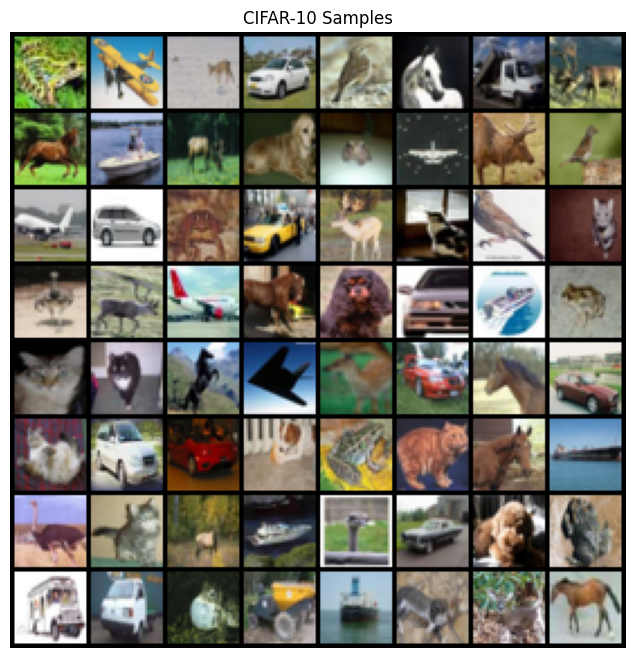

In [8]:
batch_size = 128
num_workers = 2

transform = T.Compose([
    T.ToTensor(),  
])

train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

x0, _ = next(iter(train_loader))
show_tensor_images(x0[:64], nrow=8, title="CIFAR-10 Samples")


In [9]:
def vae_loss(recon_x, x, mu, logvar, recon_type="mse"):
    if recon_type == "bce":
        recon = F.binary_cross_entropy(recon_x, x, reduction="sum")
    else:
        recon = F.mse_loss(recon_x, x, reduction="sum")
        
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl


In [10]:
class FCVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.enc = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3*32*32),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        b = x.size(0)
        x_flat = x.view(b, -1)
        h = self.enc(x_flat)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        out = self.dec_fc(z).view(b, 3, 32, 32)
        return out, mu, logvar


In [11]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 128x4x4
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
        
        self.fc = nn.Linear(latent_dim, 128*4*4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h = self.fc(z).view(-1, 128, 4, 4)
        out = self.decoder(h)
        return out, mu, logvar


In [12]:
def train_one_epoch(model, loader, optimizer, recon_type="mse"):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, recon_l, kl_l = vae_loss(recon, x, mu, logvar, recon_type=recon_type)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon_l.item()
        total_kl += kl_l.item()
    
    n = len(loader.dataset)
    return total_loss/n, total_recon/n, total_kl/n

@torch.no_grad()
def eval_one_epoch(model, loader, recon_type="mse"):
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    for x, _ in loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss, recon_l, kl_l = vae_loss(recon, x, mu, logvar, recon_type=recon_type)
        total_loss += loss.item()
        total_recon += recon_l.item()
        total_kl += kl_l.item()
    
    n = len(loader.dataset)
    return total_loss/n, total_recon/n, total_kl/n


In [13]:
@torch.no_grad()
def sample_from_prior(model, n=64, latent_dim=128):
    model.eval()
    z = torch.randn(n, latent_dim).to(device)
    
    if isinstance(model, FCVAE):
        x = model.dec_fc(z).view(n, 3, 32, 32)
    else:
        h = model.fc(z).view(-1, 128, 4, 4)
        x = model.decoder(h)
    return x


In [14]:
latent_dim = 128
epochs = 15
lr = 2e-3
recon_type = "mse"  

fc_vae = FCVAE(latent_dim=latent_dim).to(device)
opt_fc = torch.optim.Adam(fc_vae.parameters(), lr=lr)

history_fc = {"train": [], "test": []}

for ep in range(1, epochs+1):
    tr = train_one_epoch(fc_vae, train_loader, opt_fc, recon_type=recon_type)
    te = eval_one_epoch(fc_vae, test_loader, recon_type=recon_type)
    history_fc["train"].append(tr)
    history_fc["test"].append(te)
    print(f"[FCVAE] Epoch {ep:02d} | Train loss {tr[0]:.4f} (recon {tr[1]:.4f}, kl {tr[2]:.4f}) | "
          f"Test loss {te[0]:.4f}")


[FCVAE] Epoch 01 | Train loss 142.8392 (recon 134.4994, kl 8.3398) | Test loss 119.8959
[FCVAE] Epoch 02 | Train loss 115.5630 (recon 107.6183, kl 7.9447) | Test loss 112.8882
[FCVAE] Epoch 03 | Train loss 109.7824 (recon 101.9190, kl 7.8634) | Test loss 106.3899
[FCVAE] Epoch 04 | Train loss 106.0835 (recon 98.0789, kl 8.0045) | Test loss 105.2572
[FCVAE] Epoch 05 | Train loss 103.1251 (recon 94.3053, kl 8.8198) | Test loss 102.1048
[FCVAE] Epoch 06 | Train loss 101.2119 (recon 91.9802, kl 9.2317) | Test loss 100.7415
[FCVAE] Epoch 07 | Train loss 99.1473 (recon 89.3214, kl 9.8259) | Test loss 97.6361
[FCVAE] Epoch 08 | Train loss 96.4156 (recon 86.2425, kl 10.1731) | Test loss 96.1789
[FCVAE] Epoch 09 | Train loss 95.3807 (recon 85.3110, kl 10.0697) | Test loss 95.3727
[FCVAE] Epoch 10 | Train loss 94.6246 (recon 84.4718, kl 10.1528) | Test loss 94.2908
[FCVAE] Epoch 11 | Train loss 93.7825 (recon 83.6356, kl 10.1469) | Test loss 93.4611
[FCVAE] Epoch 12 | Train loss 93.3765 (recon 8

In [15]:
conv_vae = ConvVAE(latent_dim=latent_dim).to(device)
opt_conv = torch.optim.Adam(conv_vae.parameters(), lr=lr)

history_conv = {"train": [], "test": []}

for ep in range(1, epochs+1):
    tr = train_one_epoch(conv_vae, train_loader, opt_conv, recon_type=recon_type)
    te = eval_one_epoch(conv_vae, test_loader, recon_type=recon_type)
    history_conv["train"].append(tr)
    history_conv["test"].append(te)
    print(f"[ConvVAE] Epoch {ep:02d} | Train loss {tr[0]:.4f} (recon {tr[1]:.4f}, kl {tr[2]:.4f}) | "
          f"Test loss {te[0]:.4f}")


[ConvVAE] Epoch 01 | Train loss 112.4404 (recon 98.5845, kl 13.8558) | Test loss 89.8079
[ConvVAE] Epoch 02 | Train loss 83.8653 (recon 65.9731, kl 17.8922) | Test loss 83.9027
[ConvVAE] Epoch 03 | Train loss 80.1882 (recon 60.8594, kl 19.3288) | Test loss 80.6563
[ConvVAE] Epoch 04 | Train loss 78.5223 (recon 58.4982, kl 20.0242) | Test loss 77.9324
[ConvVAE] Epoch 05 | Train loss 77.7742 (recon 57.2369, kl 20.5372) | Test loss 77.4747
[ConvVAE] Epoch 06 | Train loss 77.2040 (recon 56.3236, kl 20.8804) | Test loss 77.3047
[ConvVAE] Epoch 07 | Train loss 76.7946 (recon 55.6742, kl 21.1203) | Test loss 76.7086
[ConvVAE] Epoch 08 | Train loss 76.4293 (recon 55.1416, kl 21.2877) | Test loss 76.6371
[ConvVAE] Epoch 09 | Train loss 76.2312 (recon 54.7555, kl 21.4757) | Test loss 76.3265
[ConvVAE] Epoch 10 | Train loss 76.0460 (recon 54.4658, kl 21.5802) | Test loss 76.0823
[ConvVAE] Epoch 11 | Train loss 75.8215 (recon 54.1040, kl 21.7176) | Test loss 75.8317
[ConvVAE] Epoch 12 | Train loss

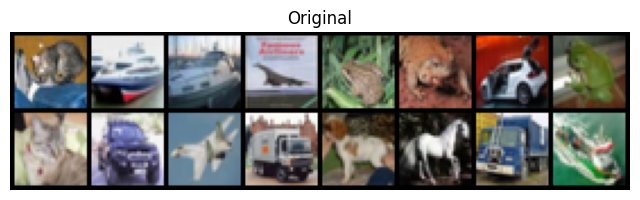

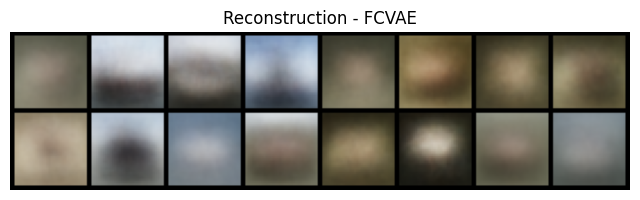

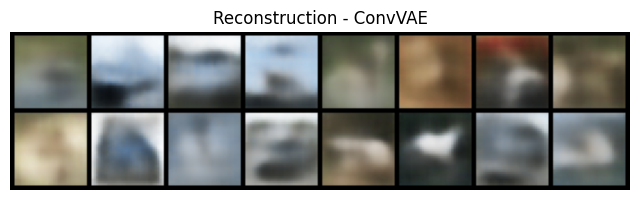

In [16]:
x, _ = next(iter(test_loader))
x = x.to(device)[:16]

fc_vae.eval()
conv_vae.eval()

with torch.no_grad():
    recon_fc, _, _ = fc_vae(x)
    recon_conv, _, _ = conv_vae(x)

show_tensor_images(x.cpu(), nrow=8, title="Original")
show_tensor_images(recon_fc.cpu(), nrow=8, title="Reconstruction - FCVAE")
show_tensor_images(recon_conv.cpu(), nrow=8, title="Reconstruction - ConvVAE")


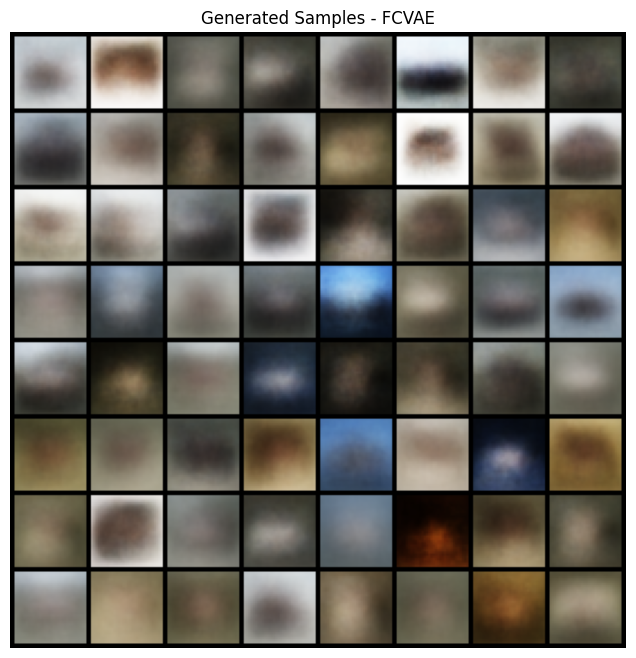

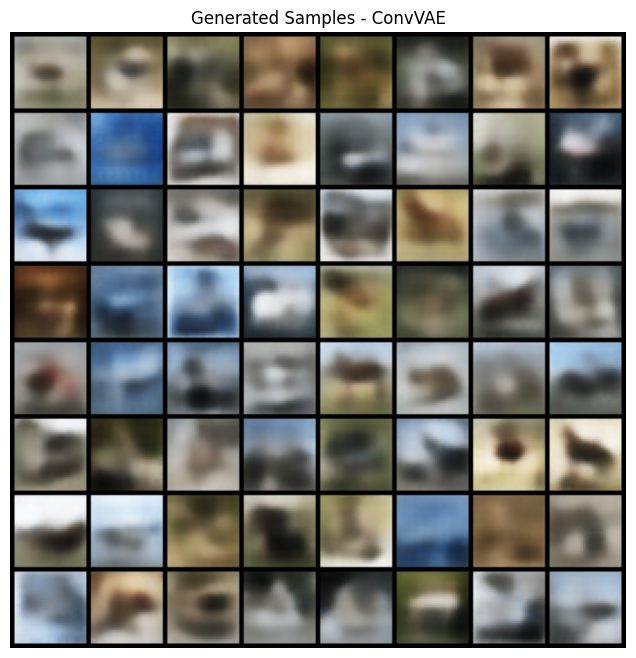

In [17]:
gen_fc = sample_from_prior(fc_vae, n=64, latent_dim=latent_dim)
gen_conv = sample_from_prior(conv_vae, n=64, latent_dim=latent_dim)

show_tensor_images(gen_fc, nrow=8, title="Generated Samples - FCVAE")
show_tensor_images(gen_conv, nrow=8, title="Generated Samples - ConvVAE")


In [18]:
@torch.no_grad()
def encode_mu(model, x):
    model.eval()
    if isinstance(model, FCVAE):
        b = x.size(0)
        h = model.enc(x.view(b, -1))
        mu = model.fc_mu(h)
        logvar = model.fc_logvar(h)
        return mu, logvar
    else:
        h = model.encoder(x).view(x.size(0), -1)
        mu = model.fc_mu(h)
        logvar = model.fc_logvar(h)
        return mu, logvar

@torch.no_grad()
def decode_z(model, z):
    model.eval()
    if isinstance(model, FCVAE):
        out = model.dec_fc(z).view(z.size(0), 3, 32, 32)
        return out
    else:
        h = model.fc(z).view(-1, 128, 4, 4)
        out = model.decoder(h)
        return out

@torch.no_grad()
def interpolate_images(model, img1, img2, steps=10):
    """
    img1, img2: Tensors [3,32,32] in [0,1]
    returns: Tensor [steps, 3, 32, 32]
    """
    mu1, _ = encode_mu(model, img1.unsqueeze(0).to(device))
    mu2, _ = encode_mu(model, img2.unsqueeze(0).to(device))
    
    alphas = torch.linspace(0, 1, steps).to(device)
    zs = torch.stack([(1-a)*mu1.squeeze(0) + a*mu2.squeeze(0) for a in alphas], dim=0)
    outs = decode_z(model, zs)
    return outs


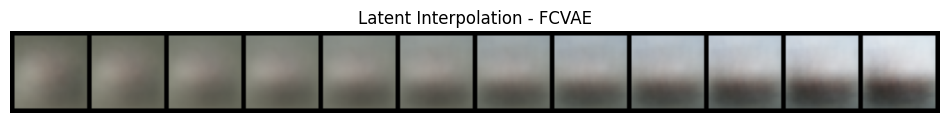

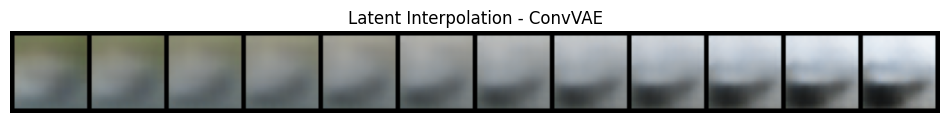

In [19]:
x, y = next(iter(test_loader))
imgA = x[0]
imgB = x[1]

steps = 12
interp_conv = interpolate_images(conv_vae, imgA, imgB, steps=steps)
interp_fc = interpolate_images(fc_vae, imgA, imgB, steps=steps)

show_tensor_images(interp_fc.cpu(), nrow=steps, title="Latent Interpolation - FCVAE")
show_tensor_images(interp_conv.cpu(), nrow=steps, title="Latent Interpolation - ConvVAE")


100.0%


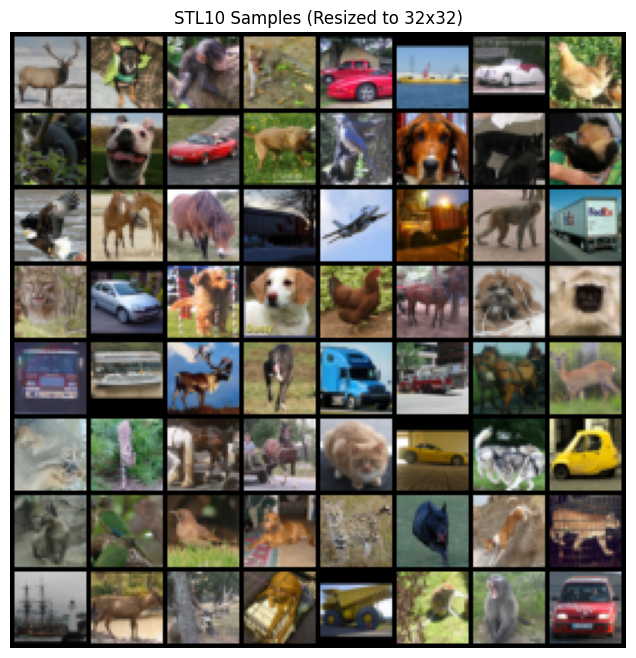

In [20]:
new_transform = T.Compose([
    T.Resize((32,32)),
    T.ToTensor(),
])

stl_train = torchvision.datasets.STL10(root="./data", split="train", download=True, transform=new_transform)
stl_test  = torchvision.datasets.STL10(root="./data", split="test", download=True, transform=new_transform)

stl_train_loader = DataLoader(stl_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
stl_test_loader  = DataLoader(stl_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

xstl, _ = next(iter(stl_train_loader))
show_tensor_images(xstl[:64], nrow=8, title="STL10 Samples (Resized to 32x32)")


In [21]:
latent_dim_new = 128
epochs_new = 12
lr_new = 2e-3

conv_vae_stl = ConvVAE(latent_dim=latent_dim_new).to(device)
opt_stl = torch.optim.Adam(conv_vae_stl.parameters(), lr=lr_new)

for ep in range(1, epochs_new+1):
    tr = train_one_epoch(conv_vae_stl, stl_train_loader, opt_stl, recon_type=recon_type)
    te = eval_one_epoch(conv_vae_stl, stl_test_loader, recon_type=recon_type)
    print(f"[ConvVAE-STL10] Epoch {ep:02d} | Train {tr[0]:.4f} | Test {te[0]:.4f}")


[ConvVAE-STL10] Epoch 01 | Train 173.6523 | Test 158.7348
[ConvVAE-STL10] Epoch 02 | Train 141.9491 | Test 126.4974
[ConvVAE-STL10] Epoch 03 | Train 119.9762 | Test 114.2218
[ConvVAE-STL10] Epoch 04 | Train 111.7537 | Test 114.1318
[ConvVAE-STL10] Epoch 05 | Train 108.1027 | Test 107.9964
[ConvVAE-STL10] Epoch 06 | Train 104.3551 | Test 103.5756
[ConvVAE-STL10] Epoch 07 | Train 101.2832 | Test 98.7149
[ConvVAE-STL10] Epoch 08 | Train 97.3779 | Test 98.2186
[ConvVAE-STL10] Epoch 09 | Train 94.2554 | Test 92.5618
[ConvVAE-STL10] Epoch 10 | Train 90.5180 | Test 94.8134
[ConvVAE-STL10] Epoch 11 | Train 88.7775 | Test 89.5275
[ConvVAE-STL10] Epoch 12 | Train 86.2914 | Test 85.7555


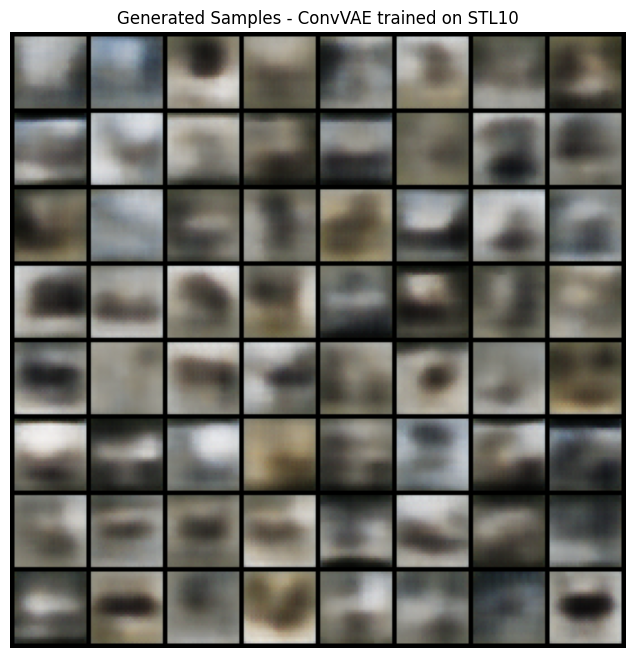

In [22]:
gen_stl = sample_from_prior(conv_vae_stl, n=64, latent_dim=latent_dim_new)
show_tensor_images(gen_stl, nrow=8, title="Generated Samples - ConvVAE trained on STL10")


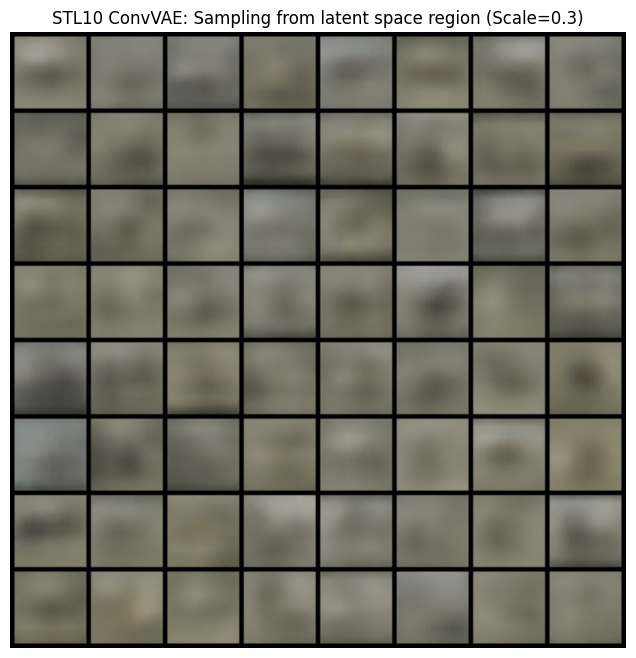

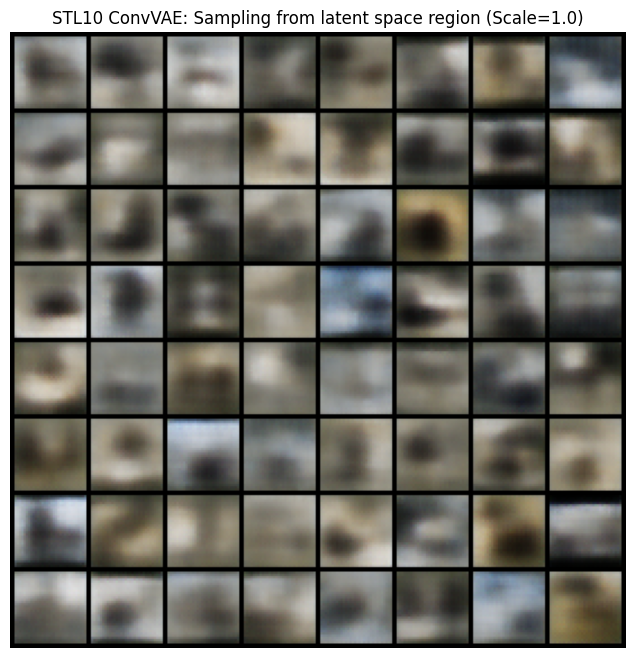

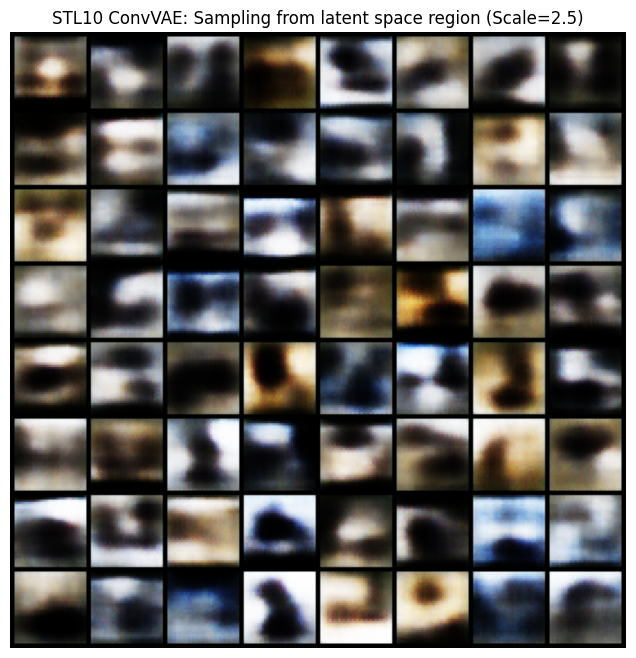

In [23]:
@torch.no_grad()
def sample_scaled(model, latent_dim, scale, n=64):
    z = torch.randn(n, latent_dim, device=device) * scale
    return decode_z(model, z)

scales = [0.3, 1.0, 2.5]

samples = []
titles = []
for s in scales:
    samples.append(sample_scaled(conv_vae_stl, latent_dim_new, scale=s, n=64).cpu())
    titles.append(f"Scale={s}")

for imgs, t in zip(samples, titles):
    show_tensor_images(imgs, nrow=8, title=f"STL10 ConvVAE: Sampling from latent space region ({t})")
